# Import packages and modules

In [1]:
import os, glob
import json
import pandas as pd
import numpy as np
import math, random
import datetime as dt
import pickle
from matplotlib import pyplot as plt
import argparse
import path, sys, re, time
from collections import Counter
from scipy.spatial import distance_matrix
from scipy.signal import find_peaks


from module_.info.testbed import activityfiles_new
from module_.info.config import config, feature_name
from module_.readText import create_episodes, time_correction, read_adlmr
from module_.featureExtraction import feature_extraction
from module_.changePointDetection import change_point_detection

## testbed

In [2]:
dir_="dataset/testbed/npy/seminar/MS"
task_dict={i:[np.load("{}/{}".format(dir_, name)) for name in v] for i, v in enumerate(activityfiles_new.values())}
initial_dict={i:k[0] for i, k in enumerate(activityfiles_new.keys())}
label_dict={k[0]:k for k in activityfiles_new.keys()}

episodes, trs, tags = create_episodes(task_dict, initial_dict)
episodes=[time_correction(eps, trs[i]) for i, eps in enumerate(episodes)]

Aircon-Door 0
Door 1
Light 2
Motion1 3
Motion2 4
Motion3 5
Motion4 6
Motion5 7
Motion6 8
Motion8 9
Motion9 10
Projector 11
Seat1B 12
Seat2A 13
Seat3A 14
Seat5A 15
Seat5B 16
Seat6A 17
Seat6B 18
1478
1478


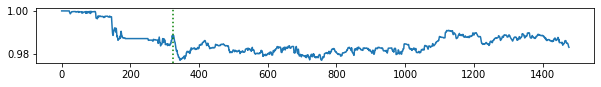

In [10]:
view_size = 5

test_idx = 0
test_chunk = episodes[test_idx]
transitions = [trs[test_idx]]

sensor_list = sorted(set(test_chunk[:,0]))

for sensor in sensor_list:
    print(sensor, sensor_list.index(sensor))

# correlation_matrix = np.diag(np.ones(len(sensor_list)))
prev_box = {sensor_:None for sensor_ in sensor_list}


prev_matrix = np.ones((len(sensor_list), len(sensor_list)))
correlation_matrix = np.ones((len(sensor_list), len(sensor_list)))
# prev1_matrix = prev2_matrix = correlation_matrix
dict_timestamps={}
l = []
r, c = (6, 3)
for i, event in enumerate(test_chunk):
    sensor = event[0]
    timestamp = float(event[2])

    if sensor not in dict_timestamps.keys():
        dict_timestamps[sensor]=[timestamp]
    else:
        dict_timestamps[sensor].append(timestamp)
    index_r = sensor_list.index(sensor)

    sensor_x = dict_timestamps[sensor][-view_size:]
    if len(sensor_x)<view_size:
        l.append(1 if len(l)==0 else l[-1])
        continue

    for sensor_ in dict_timestamps.keys():
        if sensor_==sensor:
            continue
        sensor_y = dict_timestamps[sensor_][-view_size:]
        index_c = sensor_list.index(sensor_)

        if len(sensor_y)<view_size:
            continue
        if prev_box[sensor_]==sensor_y:
            correlation_matrix[index_r, index_c] = prev_matrix[index_r, index_c]
            correlation_matrix[index_c, index_r] = prev_matrix[index_r, index_c]
        else:
        # col.append(np.corrcoef(sensor_x, sensor_y)[0,1])
            correl = np.corrcoef(sensor_x, sensor_y)[0,1]
            correlation_matrix[index_r, index_c]=correl
            correlation_matrix[index_c, index_r]=correl

            prev_matrix[index_r, index_c] = correl
            prev_matrix[index_c, index_r] = correl

            prev_box[sensor_] = sensor_y
    # l.append(np.average(correlation_matrix+prev1_matrix+prev2_matrix)/3)
    l.append(np.average(correlation_matrix))
    # prev2_matrix = prev1_matrix
    # prev1_matrix = correlation_matrix
    
print(len(test_chunk))
print(len(l))
    
fig = plt.figure(figsize=(10, 1))
ax = fig.add_subplot(1, 1, 1)

ax.plot(range(len(l)), l)
for t in transitions:
    plt.axvline(x=t, linestyle=':', color='g')

(1478, 30)
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1.0, 1.0, 1.0, 1.0, 0.9999881972226413, 0.9993632439787947, 0.9989921559522041, 0.9986265784431194, 0.9988818195692105, 0.999097403863565, 0.9993365817135386, 0.9996162572537504, 0.99962892858451]


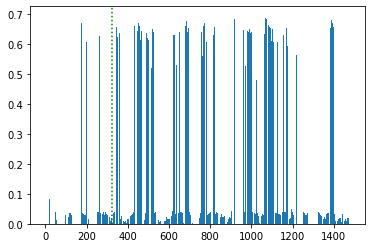

In [11]:
window_size = 30
metric = 'RuLSIF'
features = []
for i in range(len(l)):
    bucket=[]
    idx=i-window_size+1
    while idx<=i:
        bucket.append(l[max(0, idx)])
        idx+=1
    
    features.append(bucket)

print(np.array(features).shape)
print(features[0])
print(features[30])

scores = np.array(change_point_detection(features, "", metric))
scores[scores<0] = 0
assert len(scores) == len(l)
plt.bar(range(len(scores)), scores)
for t in transitions:
    plt.axvline(x=t, linestyle=':', color='g')

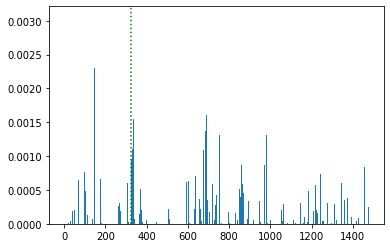

In [15]:
ll = []
for i in range(len(l)-1):
    ll.append(l[i]-l[i+1])
ll = np.array(ll)
ll[ll<0]=0
plt.bar(range(len(ll)), ll)
for t in transitions:
    plt.axvline(x=t, linestyle=':', color='g')

In [ ]:
sorted(set(test_chunk[:,0]))

## adlmr

In [ ]:
f = open("./dataset/adlmr/annotated", 'rb')
text = f.readlines()
tasks = read_adlmr(text)

## hh

In [ ]:
# load dataset
directory_hh101="./dataset/hh/hh101/ann.txt"

f=open(directory_hh101, 'r')
txt=f.readlines()
events=[]
activity = "Idle"
for i, line in enumerate(txt):
    event = []
    
    try:
        f_info = line.split()
        # Date, time, sensor, value, (label)

        event.append(f_info[2])
        event.append(f_info[3])
        if not ('.' in str(np.array(f_info[0])) + f_info[1]):
            f_info[1] = f_info[1] + '.000000'
        timestamp=datetime.timestamp(datetime.strptime(f_info[0] + f_info[1], "%Y-%m-%d%H:%M:%S.%f"))
        event.append(float(timestamp))           # 3. timestamp

        if len(f_info) != 4: # label
            label = str(' '.join(np.array(f_info[4:])))
            if 'begin' in label:
                activity = label.split('=')[0].strip()
                event.append(activity)
            elif 'end' in label:
                event.append(activity)
                activity = "Idle"
            else:
                event.append(activity)
        else:
            event.append(activity)
        
        events.append(event)

    except:
        print("SKIP")

raw_length = len(events)

print(Counter(np.array(events)[:,3]))

In [ ]:
events = [e for e in events if e[0][0] in list('MD')]

startindices = [i for i in range(1, len(events)) if events[i][3]!=events[i-1][3]]
startindices = [0]+startindices+[len(events)]

dict_consecutiveActivities = {
    'chunks':[],
    'labels':[],
    'lengths':[],
}

chunksize = 8

CoC=[]
CoLbl=[]
CoLen=[]
for i in range(len(startindices)-1):
    start, end_ = startindices[i:i+2]
    chunk=events[start:end_]

    labelset = list(set(np.array(chunk)[:,3]))
    assert len(labelset)==1
    label = labelset[0]

    if len(CoC)==chunksize:
        dict_consecutiveActivities['chunks'].append(CoC)
        dict_consecutiveActivities['labels'].append(CoLbl)
        dict_consecutiveActivities['lengths'].append(CoLen)
        # CoC = CoLbl = CoLen = []
        CoC, CoLbl, CoLen = [], [], []

    CoC.append(chunk)
    CoLbl.append(label)
    CoLen.append(len(chunk))

In [ ]:
"""Test: Second Chunks"""
ti = 3
test_chunk = np.concatenate(dict_consecutiveActivities['chunks'][ti])
test_label = dict_consecutiveActivities['labels'][ti]
test_length = dict_consecutiveActivities['lengths'][ti]

print(test_chunk.shape, test_label, test_length)

transitions = []
start=0
for i in range(len(test_length)-1):
    transitions.append(start+test_length[i])
    start+=test_length[i]


In [ ]:
# window_size = 30
view_size = 5

sensor_list = sorted(set(test_chunk[:,0]))

for sensor in sensor_list:
    print(sensor, sensor_list.index(sensor))

# correlation_matrix = np.diag(np.ones(len(sensor_list)))
correlation_matrix = np.ones((len(sensor_list), len(sensor_list)))
prev1_matrix = prev2_matrix = correlation_matrix
dict_timestamps={}
l = []
r, c = (6, 3)
for i, event in enumerate(test_chunk):
    sensor = event[0]
    timestamp = float(event[2])

    if sensor not in dict_timestamps.keys():
        dict_timestamps[sensor]=[timestamp]
    else:
        dict_timestamps[sensor].append(timestamp)
    index_r = sensor_list.index(sensor)

    sensor_x = dict_timestamps[sensor][-view_size:]
    if len(sensor_x)<view_size:
        l.append(1 if len(l)==0 else l[-1])
        continue

    for sensor_ in dict_timestamps.keys():
        if sensor_==sensor:
            continue
        sensor_y = dict_timestamps[sensor_][-view_size:]
        if len(sensor_y)<view_size:
            continue
        index_c = sensor_list.index(sensor_)
        # col.append(np.corrcoef(sensor_x, sensor_y)[0,1])
        correlation_matrix[index_r, index_c]=np.corrcoef(sensor_x, sensor_y)[0,1]
        correlation_matrix[index_c, index_r]=np.corrcoef(sensor_x, sensor_y)[0,1]
    l.append(np.average(correlation_matrix+prev1_matrix+prev2_matrix)/3)
    prev2_matrix = prev1_matrix
    prev1_matrix = correlation_matrix
    
print(len(test_chunk))
print(len(l))
    
fig = plt.figure(figsize=(10, 1))
ax = fig.add_subplot(1, 1, 1)

ax.plot(range(len(l)), l)
for t in transitions:
    plt.axvline(x=t, linestyle=':', color='g')

## testbed